In [39]:
import os
import datetime
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torchvision
from torch import nn
from torch.optim import Adam, lr_scheduler
from torch.nn.functional import softmax, relu
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

import cv2
from PIL import Image

from torchvision.models import resnet18
from torchvision import transforms
from torchvision.datasets import Caltech101

from torchinfo import summary

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay, confusion_matrix, ConfusionMatrixDisplay


In [40]:
!pip install torch

Defaulting to user installation because normal site-packages is not writeable


In [41]:
!pip install torchvision

!pip install torchinfo
!pip install sklearn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Data preparation

In [42]:
from torchvision.datasets.utils import download_and_extract_archive, extract_archive


class Caltech101Fixed(Caltech101):

    def __init__(self, root: str, target_type="category", transform=None,
                 target_transform=None, download: bool = False) -> None:
        super().__init__(root, target_type, transform, target_transform, download)

    def download(self) -> None:
        download_and_extract_archive(
            "https://data.caltech.edu/tindfiles/serve/e41f5188-0b32-41fa-801b-d1e840915e80",
            self.root,
            md5="3138E1922A9193BFA496528EDBBC45D0".lower(),
            filename="caltech-101.zip"
        )

        extract_archive(self.root + "/caltech-101/101_ObjectCategories.tar.gz", self.root, True)

        extract_archive(self.root + "/caltech-101/Annotations.tar", self.root, True)

In [43]:
data_transform = transforms.Compose([
    transforms.Resize([(32, 32)]),
    transforms.Lambda(lambda img: img.convert("RGB")),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

data = Caltech101Fixed("./data/", download=True, transform=data_transform,
                       target_transform=lambda y: torch.zeros(101, dtype=torch.float).scatter_(0, torch.tensor(y),
                                                                                               value=1))

Using downloaded and verified file: ./data/caltech101/caltech-101.zip
Extracting ./data/caltech101/caltech-101.zip to ./data/caltech101


In [44]:
batch_size = 16

train, test = random_split(data, [int(len(data) * 0.67), len(data) - int(len(data) * 0.67)])

train_data_loader = torch.utils.data.DataLoader(train, batch_size)
test_data_loader = torch.utils.data.DataLoader(test, batch_size)

# CNN

In [45]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=20, out_channels=64, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.relu1 = nn.ReLU()
        self.MaxPool1 = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(12800, 101)
        self.relu2 = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = relu(x)
        x = self.conv2(x)
        x = relu(x)
        x = self.conv3(x)
        x = self.relu1(x)
        x = self.MaxPool1(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc1(x)
        out = self.relu2(x)

        return out

In [46]:
def train_loop(dataloader, model, criterion, optimizer):
    size = len(dataloader.dataset)
    loss, accuracy = 0, 0
    model.train()
    for batch, (inputs, labels) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(inputs)
        loss_batch = criterion(pred, labels)
        loss_batch.backward()
        optimizer.step()
        loss += float(loss_batch.item())
        accuracy += (pred.argmax(1) == labels.argmax(1)).type(torch.float).sum().item()
        

    print(f"Train: \nAccuracy: {100 * accuracy / size}%, Loss: {loss/len(dataloader)} ")

In [47]:
def test_loop(dataloader, model, criterion):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, accuracy = 0, 0

    with torch.no_grad():
        model.eval()
        for batch, (inputs, labels) in enumerate(dataloader):
            pred = model(inputs)
            loss_batch = criterion(pred, labels)
            accuracy += (pred.argmax(1) == labels.argmax(1)).type(torch.float).sum().item()
            loss += float(loss_batch.item())
            
    accuracy /= size
    loss /= num_batches

    print(f"Test:\nAccuracy: {(100 * accuracy)}%, Loss: {loss} \n")

    return accuracy

In [48]:
model = Net()

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
epochs = 15

best_acc = 0
best_model_wts = copy.deepcopy(model.state_dict())
val_acc_history = []

for t in range(epochs):
    print(f"Epoch {t + 1}")
    train_loop(train_data_loader, model, criterion, optimizer)
    epoch_acc = test_loop(test_data_loader, model, criterion)
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        print(f'New best accuracy: {best_acc}.')
    val_acc_history.append(epoch_acc)

Epoch 1
Train: 
Accuracy: 23.92912437639773%, Loss: 3.7956938475042907 
Test:
Accuracy: 29.748603351955303%, Loss: 3.44055657280224 

New best accuracy: 0.29748603351955305.
Epoch 2
Train: 
Accuracy: 36.52158954068467%, Loss: 3.1953805737443024 
Test:
Accuracy: 36.312849162011176%, Loss: 3.1629698090047143 

New best accuracy: 0.36312849162011174.
Epoch 3
Train: 
Accuracy: 42.559779803887835%, Loss: 2.8871026906993364 
Test:
Accuracy: 41.02653631284916%, Loss: 2.9704272940172163 

New best accuracy: 0.4102653631284916.
Epoch 4
Train: 
Accuracy: 48.51195596077757%, Loss: 2.6003338380174323 
Test:
Accuracy: 43.81983240223464%, Loss: 2.799445052386662 

New best accuracy: 0.4381983240223464.
Epoch 5
Train: 
Accuracy: 54.79098572165835%, Loss: 2.27037710246149 
Test:
Accuracy: 46.54329608938548%, Loss: 2.6934476171791886 

New best accuracy: 0.4654329608938548.
Epoch 6
Train: 
Accuracy: 62.10218475830036%, Loss: 1.9376175512488072 
Test:
Accuracy: 49.127094972067034%, Loss: 2.5683602607450

In [50]:
y_pred_cnn = []
y_cnn = []
confidence_cnn = []

with torch.no_grad():
    model.eval()
    for batch, (X, y) in enumerate(test_data_loader):
        
        pred = softmax(model(X))
        y_cnn.append(y.argmax(1).numpy())
        y_pred_cnn.append(pred.argmax(1).cpu().numpy())
        max_v, _ = pred.max(1)
        confidence_cnn.append(max_v.cpu().numpy())

y_pred_cnn = np.concatenate([i.squeeze() for i in y_pred_cnn])
y_cnn = np.concatenate([i.squeeze() for i in y_cnn])
confidence_cnn = np.concatenate([i.squeeze() for i in confidence_cnn])

/tmp/ipykernel_93703/531837272.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(model(X))


# Frozen pre-trained ResNet as feature extractor

In [51]:
model_conv_frozen=torchvision.models.resnet18(pretrained=True)

for param in model_conv_frozen.parameters():
    param.requires_grad=False
    
num_ftrs = model_conv_frozen.fc.in_features
model_conv_frozen.fc = nn.Linear(num_ftrs, 101)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_conv_frozen.parameters(), lr=0.01)
epochs = 15

best_acc_frozen = 0
best_model_wts_frozen = copy.deepcopy(model_conv_frozen.state_dict())
val_acc_history_frozen = []

for t in range(epochs):
    
    print(f"Epoch {t + 1}")
    train_loop(train_data_loader, model_conv_frozen, criterion, optimizer)
    epoch_acc = test_loop(test_data_loader, model_conv_frozen, criterion)
    if epoch_acc > best_acc_frozen:
        best_acc_frozen = epoch_acc
        best_model_wts_frozen = copy.deepcopy(model_conv_frozen.state_dict())
        print(f'New best accuracy: {best_acc_frozen}.')
    val_acc_history_frozen.append(epoch_acc)

Epoch 1
Train: 
Accuracy: 24.479614656803715%, Loss: 3.703389583708166 
Test:
Accuracy: 31.98324022346369%, Loss: 3.2692049468695785 

New best accuracy: 0.3198324022346369.
Epoch 2
Train: 
Accuracy: 37.29571649750559%, Loss: 2.8445242636806363 
Test:
Accuracy: 35.19553072625698%, Loss: 3.0040187762436252 

New best accuracy: 0.35195530726256985.
Epoch 3
Train: 
Accuracy: 43.62635472217443%, Loss: 2.4491016288380045 
Test:
Accuracy: 37.43016759776536%, Loss: 2.9031458813384923 

New best accuracy: 0.3743016759776536.
Epoch 4
Train: 
Accuracy: 48.16789953552382%, Loss: 2.188454053559146 
Test:
Accuracy: 38.93156424581006%, Loss: 2.8602711821401585 

New best accuracy: 0.3893156424581006.
Epoch 5
Train: 
Accuracy: 52.46860485119559%, Loss: 1.9935067820025014 
Test:
Accuracy: 40.29329608938548%, Loss: 2.8444788096337343 

New best accuracy: 0.4029329608938548.
Epoch 6
Train: 
Accuracy: 55.75434371236883%, Loss: 1.8377122897040712 
Test:
Accuracy: 40.81703910614525%, Loss: 2.84349205107662

In [53]:
y_pred_frozen = []
y_frozen = []
confidence_frozen = []

with torch.no_grad():
    model_conv_frozen.eval()
    for batch, (X, y) in enumerate(test_data_loader):
        pred = softmax(model_conv_frozen(X))
        y_frozen.append(y.argmax(1).numpy())
        y_pred_frozen.append(pred.argmax(1).cpu().numpy())
        max_v, _ = pred.max(1)
        confidence_frozen.append(max_v.cpu().numpy())

y_pred_frozen = np.concatenate([i.squeeze() for i in y_pred_frozen])
y_frozen = np.concatenate([i.squeeze() for i in y_frozen])
confidence_frozen = np.concatenate([i.squeeze() for i in confidence_frozen])

/tmp/ipykernel_93703/2765403940.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(model_conv_frozen(X))


# Fine-tuned pre-trained ResNet

In [54]:
fine_tuned = resnet18(pretrained=True)

num_ftrs = fine_tuned.fc.in_features
fine_tuned.fc = nn.Linear(num_ftrs, 101)

In [55]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(fine_tuned.parameters(), lr=0.01)
epochs = 10

best_acc_fine_tuned = 0
best_model_wts_fine_tuned = copy.deepcopy(fine_tuned.state_dict())
val_acc_history_fine_tuned = []
for t in range(epochs):
    print(f"Epoch {t + 1}")
    train_loop(train_data_loader, fine_tuned, criterion, optimizer)
    epoch_acc = test_loop(test_data_loader, fine_tuned, criterion)
    if epoch_acc > best_acc_fine_tuned:
        best_acc_fine_tuned = epoch_acc
        best_model_wts_fine_tuned = copy.deepcopy(fine_tuned.state_dict())
        print(f'New best accuracy: {best_acc_fine_tuned}.')
    val_acc_history_fine_tuned.append(epoch_acc)

Epoch 1
Train: 
Accuracy: 39.583691725442975%, Loss: 2.8113651678457363 
Test:
Accuracy: 48.358938547486034%, Loss: 2.349250116494781 

New best accuracy: 0.48358938547486036.
Epoch 2
Train: 
Accuracy: 61.89575090314812%, Loss: 1.5490415172016883 
Test:
Accuracy: 59.986033519553075%, Loss: 1.7518153333797135 

New best accuracy: 0.5998603351955307.
Epoch 3
Train: 
Accuracy: 82.84878720110098%, Loss: 0.7025091971301443 
Test:
Accuracy: 63.268156424581%, Loss: 1.640843274373582 

New best accuracy: 0.63268156424581.
Epoch 4
Train: 
Accuracy: 97.0755203853432%, Loss: 0.21261508559173609 
Test:
Accuracy: 65.46787709497207%, Loss: 1.6186299756918539 

New best accuracy: 0.6546787709497207.
Epoch 5
Train: 
Accuracy: 99.89678307242387%, Loss: 0.04943967409749198 
Test:
Accuracy: 65.22346368715084%, Loss: 1.632221329811565 

Epoch 6
Train: 
Accuracy: 100.0%, Loss: 0.018262897863738484 
Test:
Accuracy: 65.88687150837988%, Loss: 1.6389234312419785 

New best accuracy: 0.6588687150837989.
Epoch 7

In [56]:
y_pred_fine_tuned = []
y_fine_tuned = []
confidence_fine_tuned = []

with torch.no_grad():
    fine_tuned.eval()
    for batch, (X, y) in enumerate(test_data_loader):
        pred = softmax(fine_tuned(X))
        y_fine_tuned.append(y.argmax(1).numpy())
        y_pred_fine_tuned.append(pred.argmax(1).cpu().numpy())
        max_v, _ = pred.max(1)
        confidence_fine_tuned.append(max_v.cpu().numpy())

y_pred_fine_tuned = np.concatenate([i.squeeze() for i in y_pred_fine_tuned])
y_fine_tuned = np.concatenate([i.squeeze() for i in y_fine_tuned])
confidence_fine_tuned = np.concatenate([i.squeeze() for i in confidence_fine_tuned])

/tmp/ipykernel_93703/723224873.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = softmax(fine_tuned(X))


# Attach train/validation results reported in the following form

## 101x101 confusion matrices

Plot saved


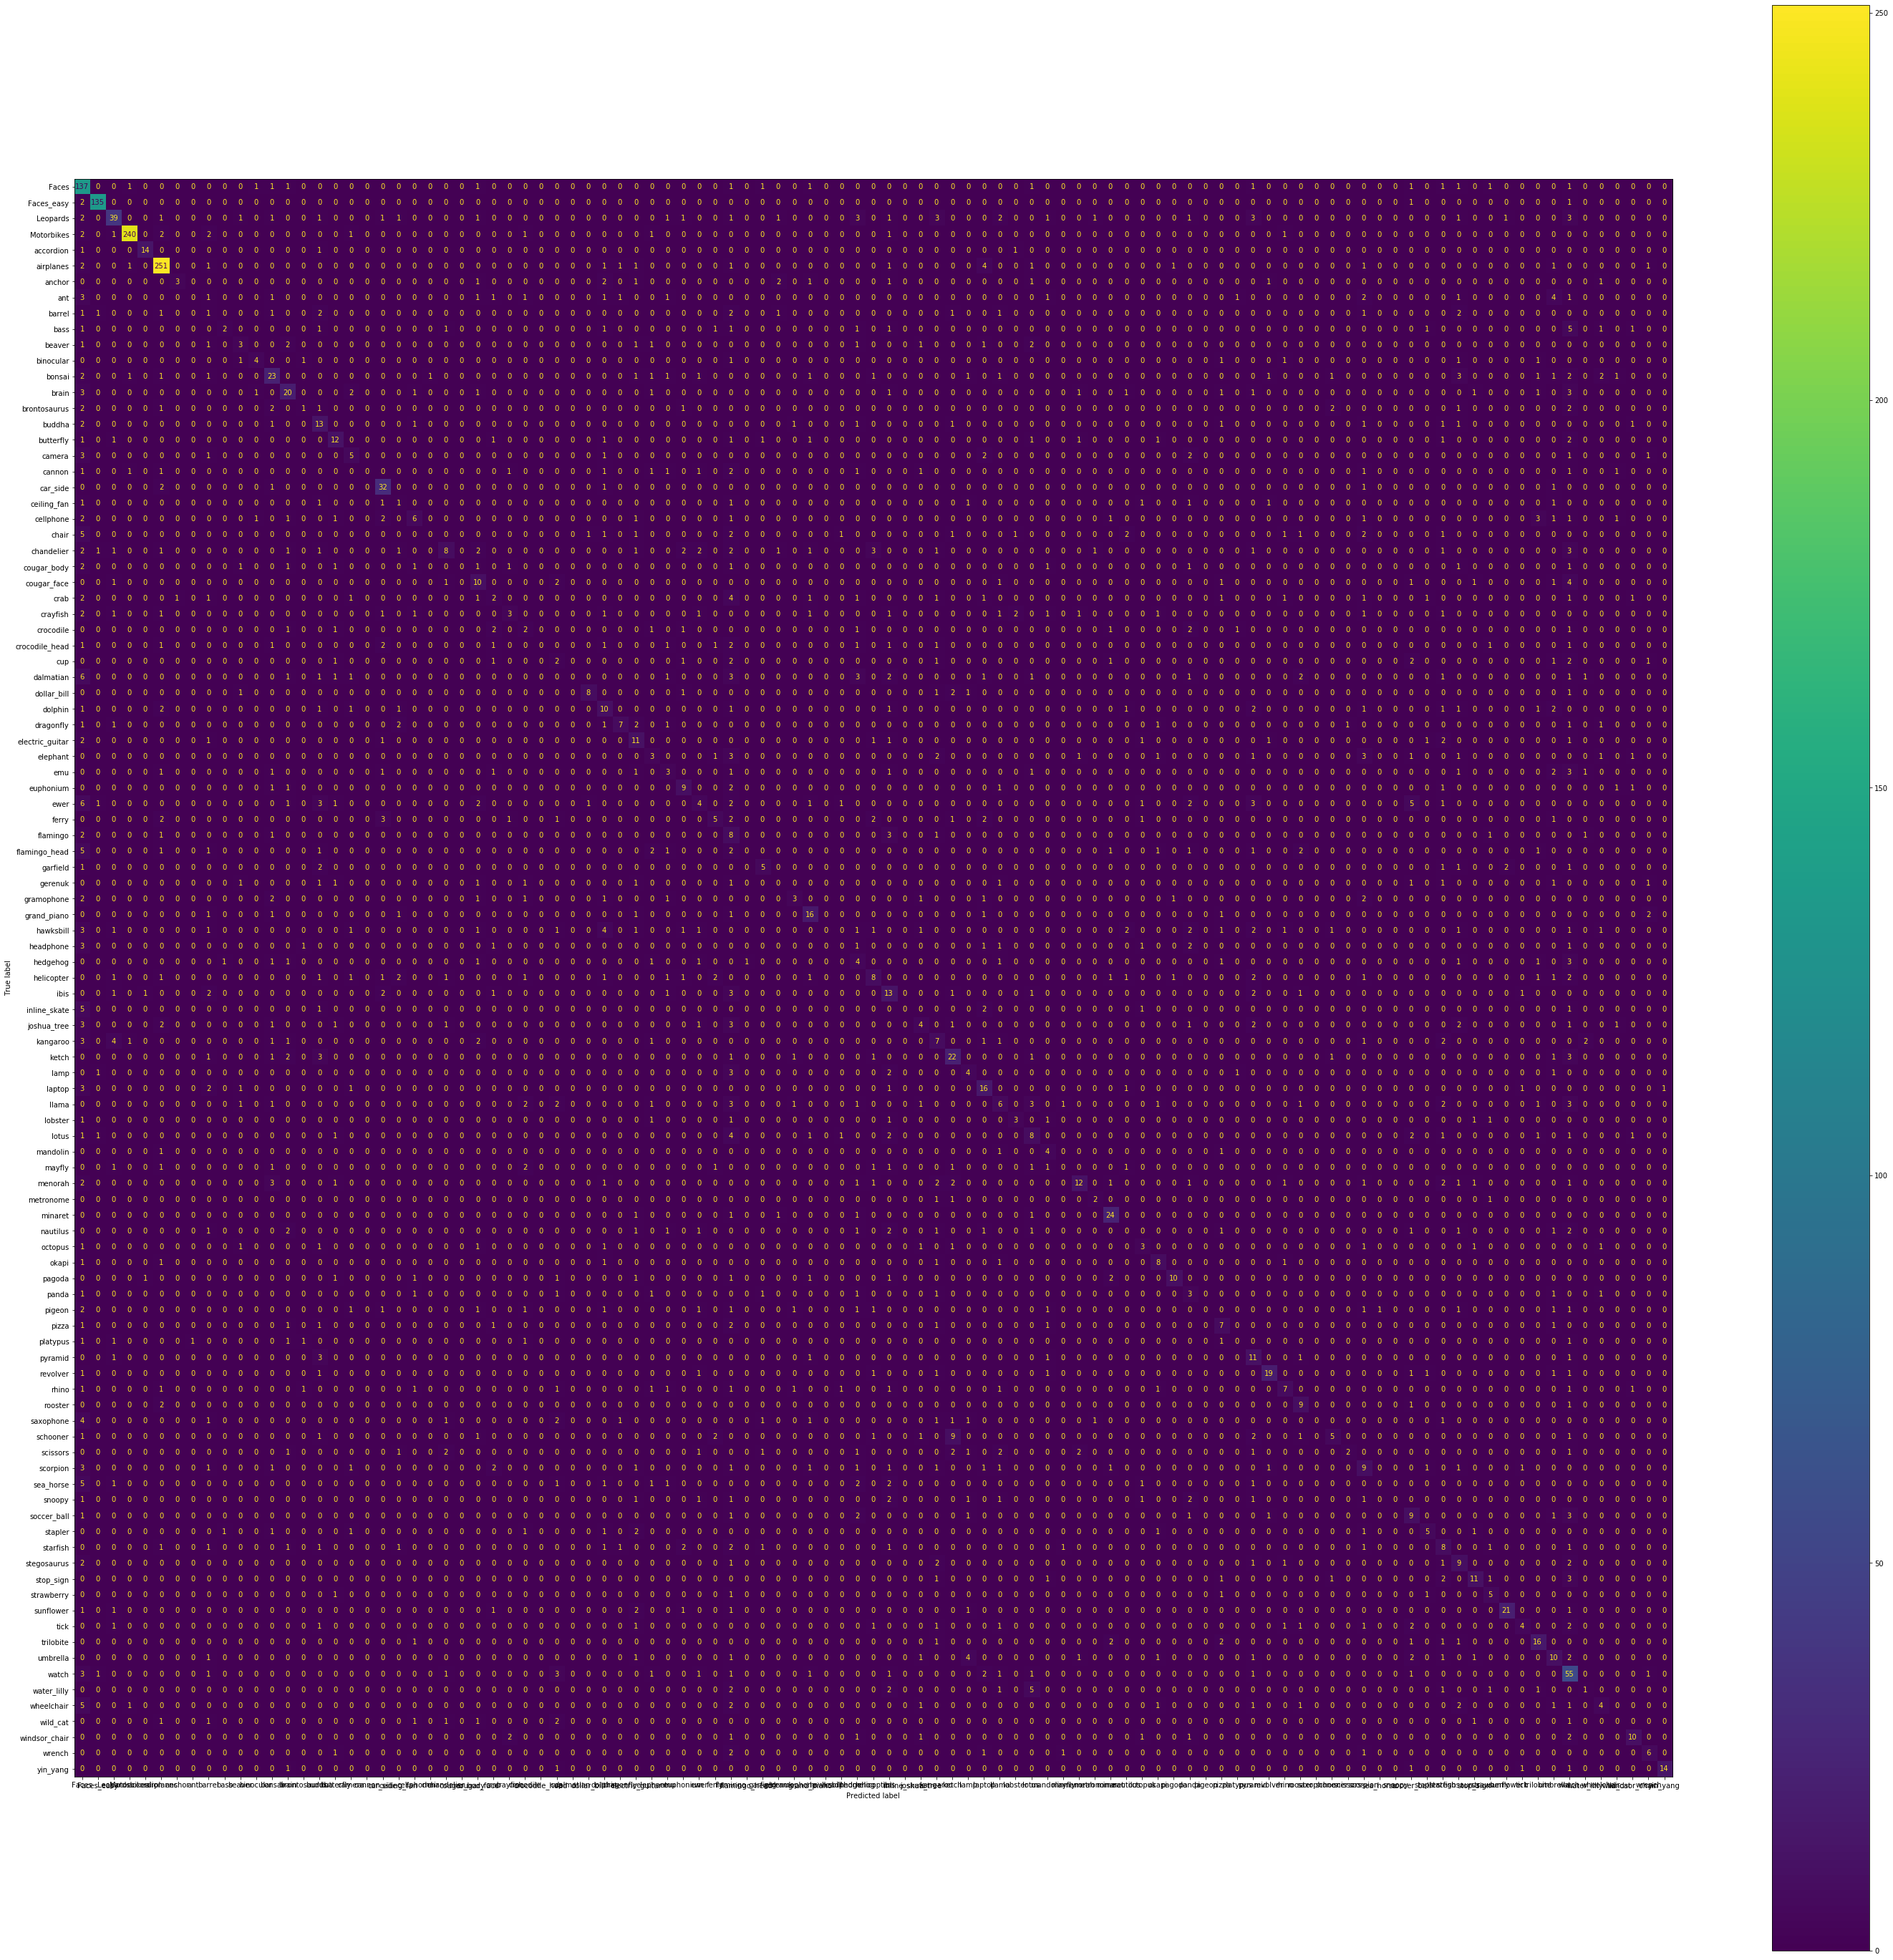

In [57]:
cm_cnn = confusion_matrix(y_cnn, y_pred_cnn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn, display_labels=data.categories)
fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)
disp.figure_.savefig('conf_mat_cnn.png')
print("Plot saved")
plt.show()

Plot saved


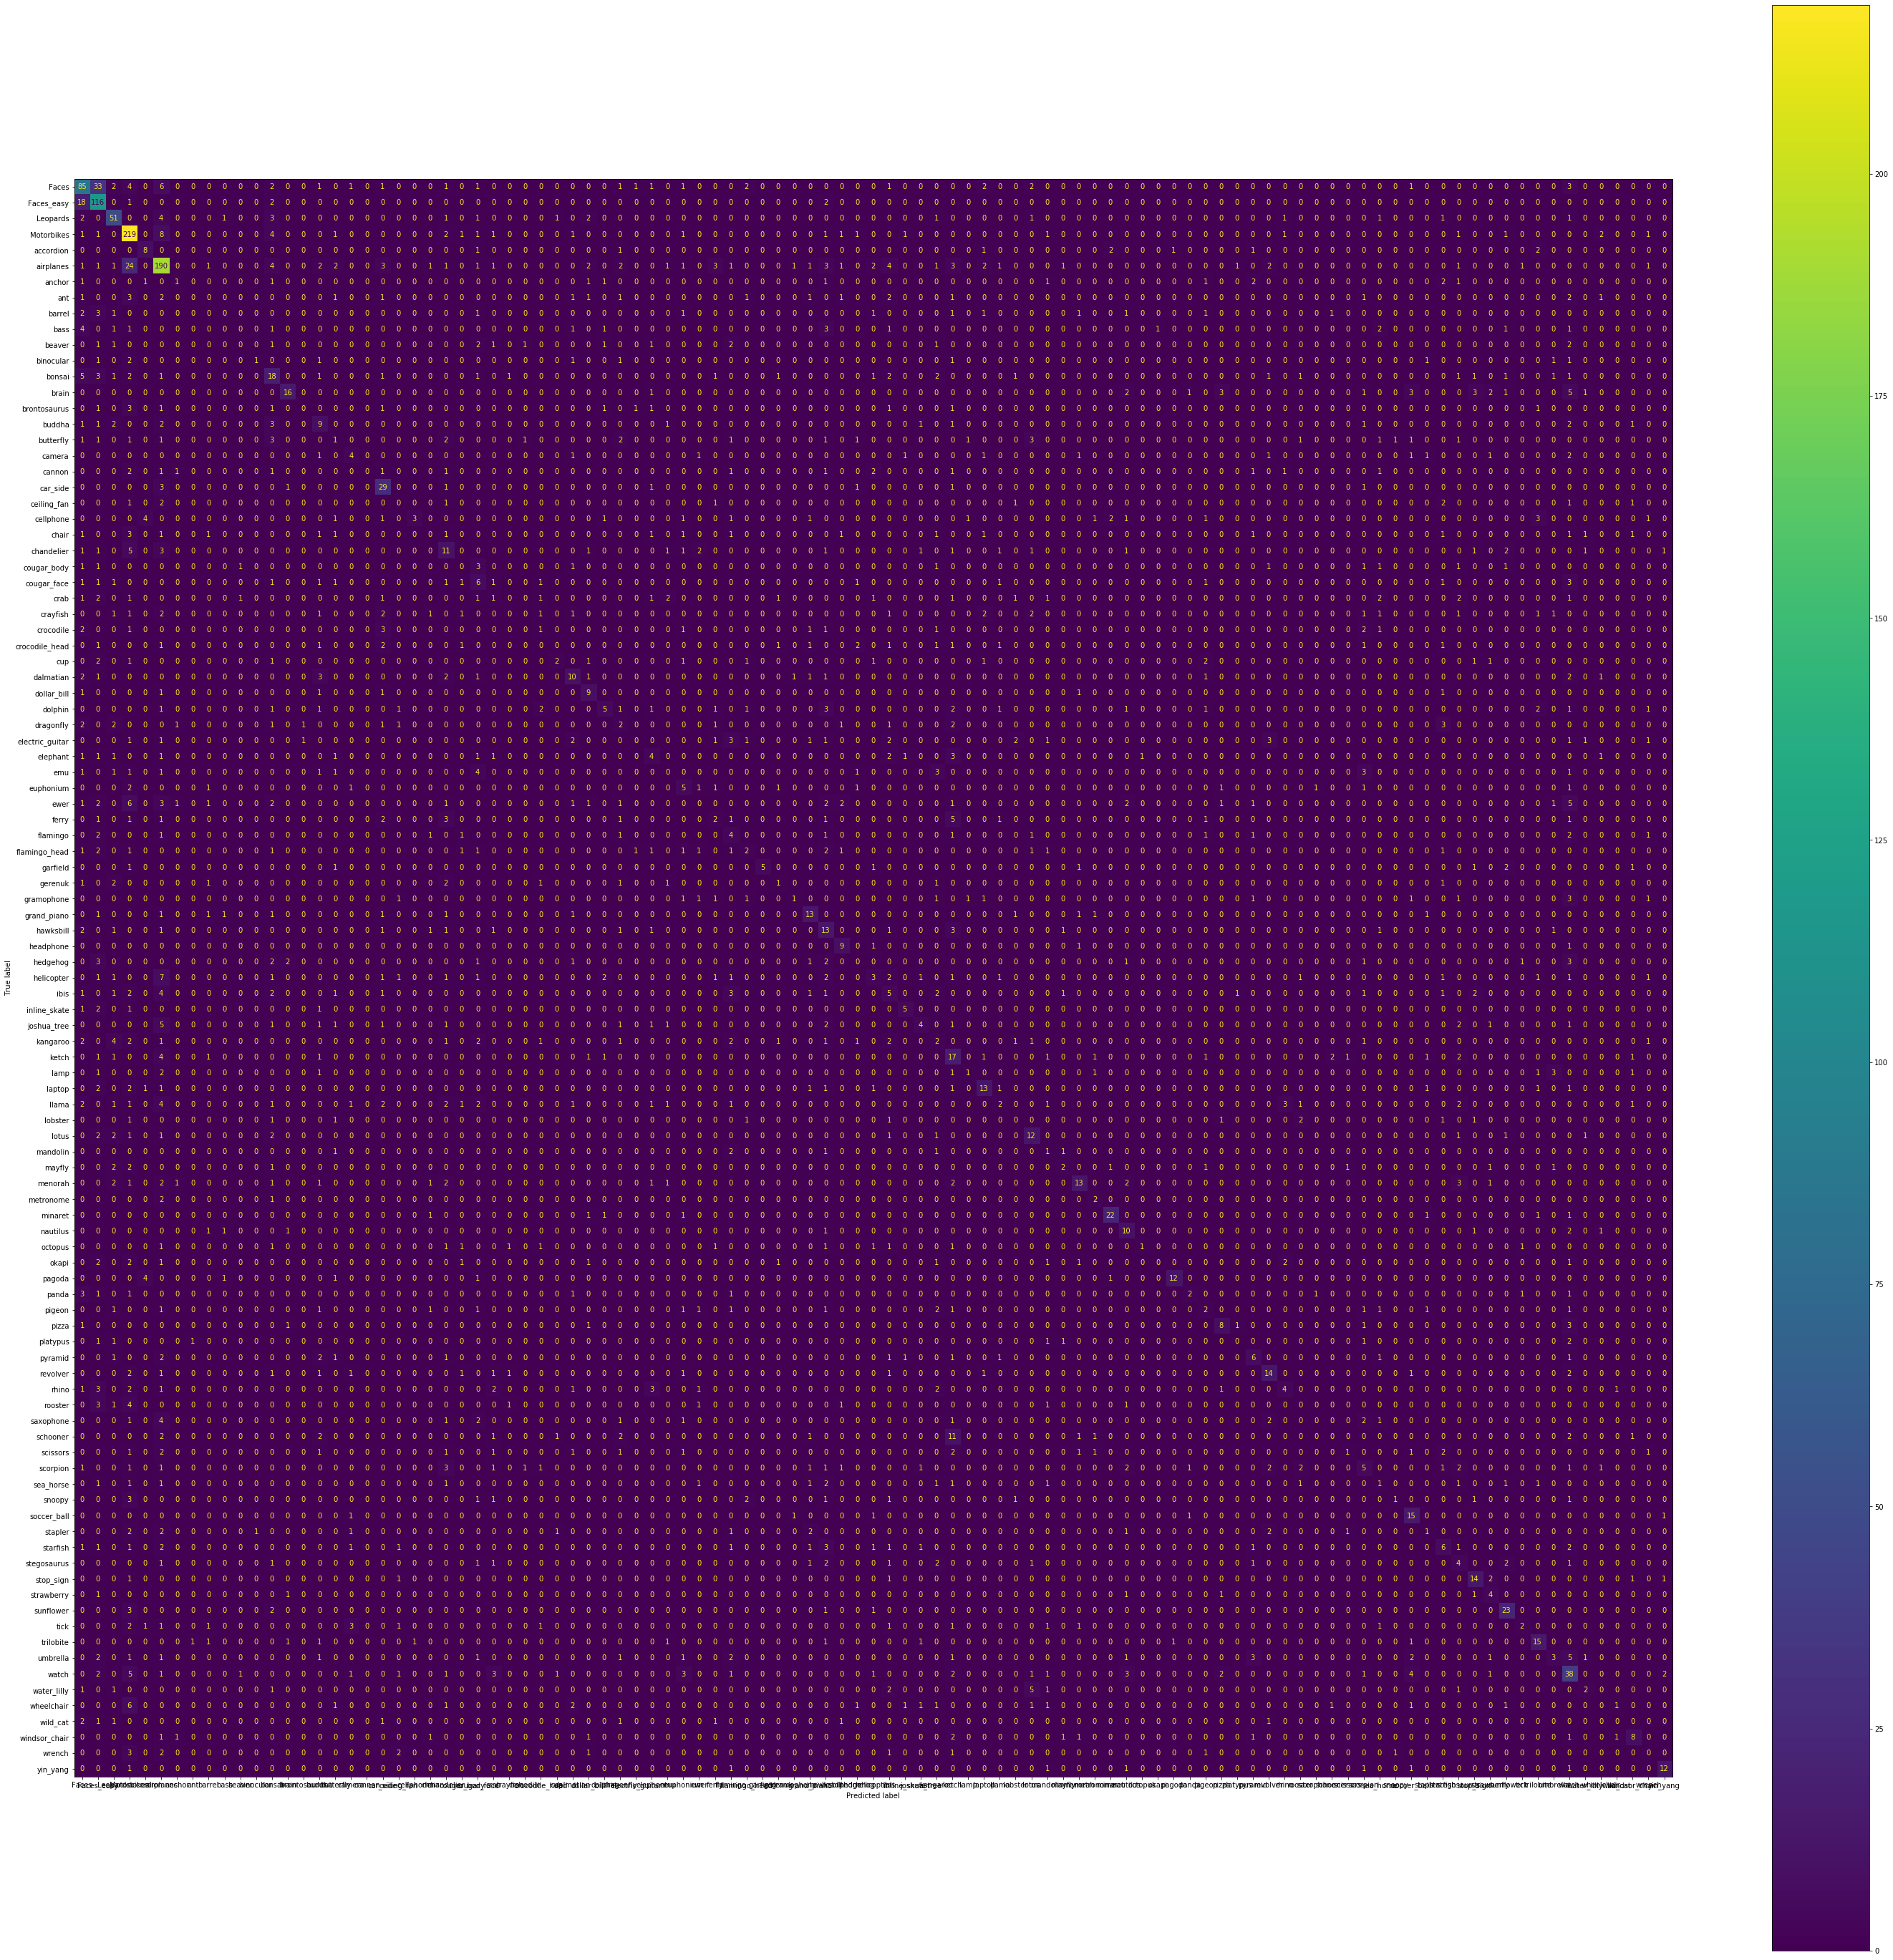

In [58]:
cm_frozen = confusion_matrix(y_frozen, y_pred_frozen)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_frozen, display_labels=data.categories)
fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)
disp.figure_.savefig('conf_mat_frozen.png')
print("Plot saved")
plt.show()

Plot saved


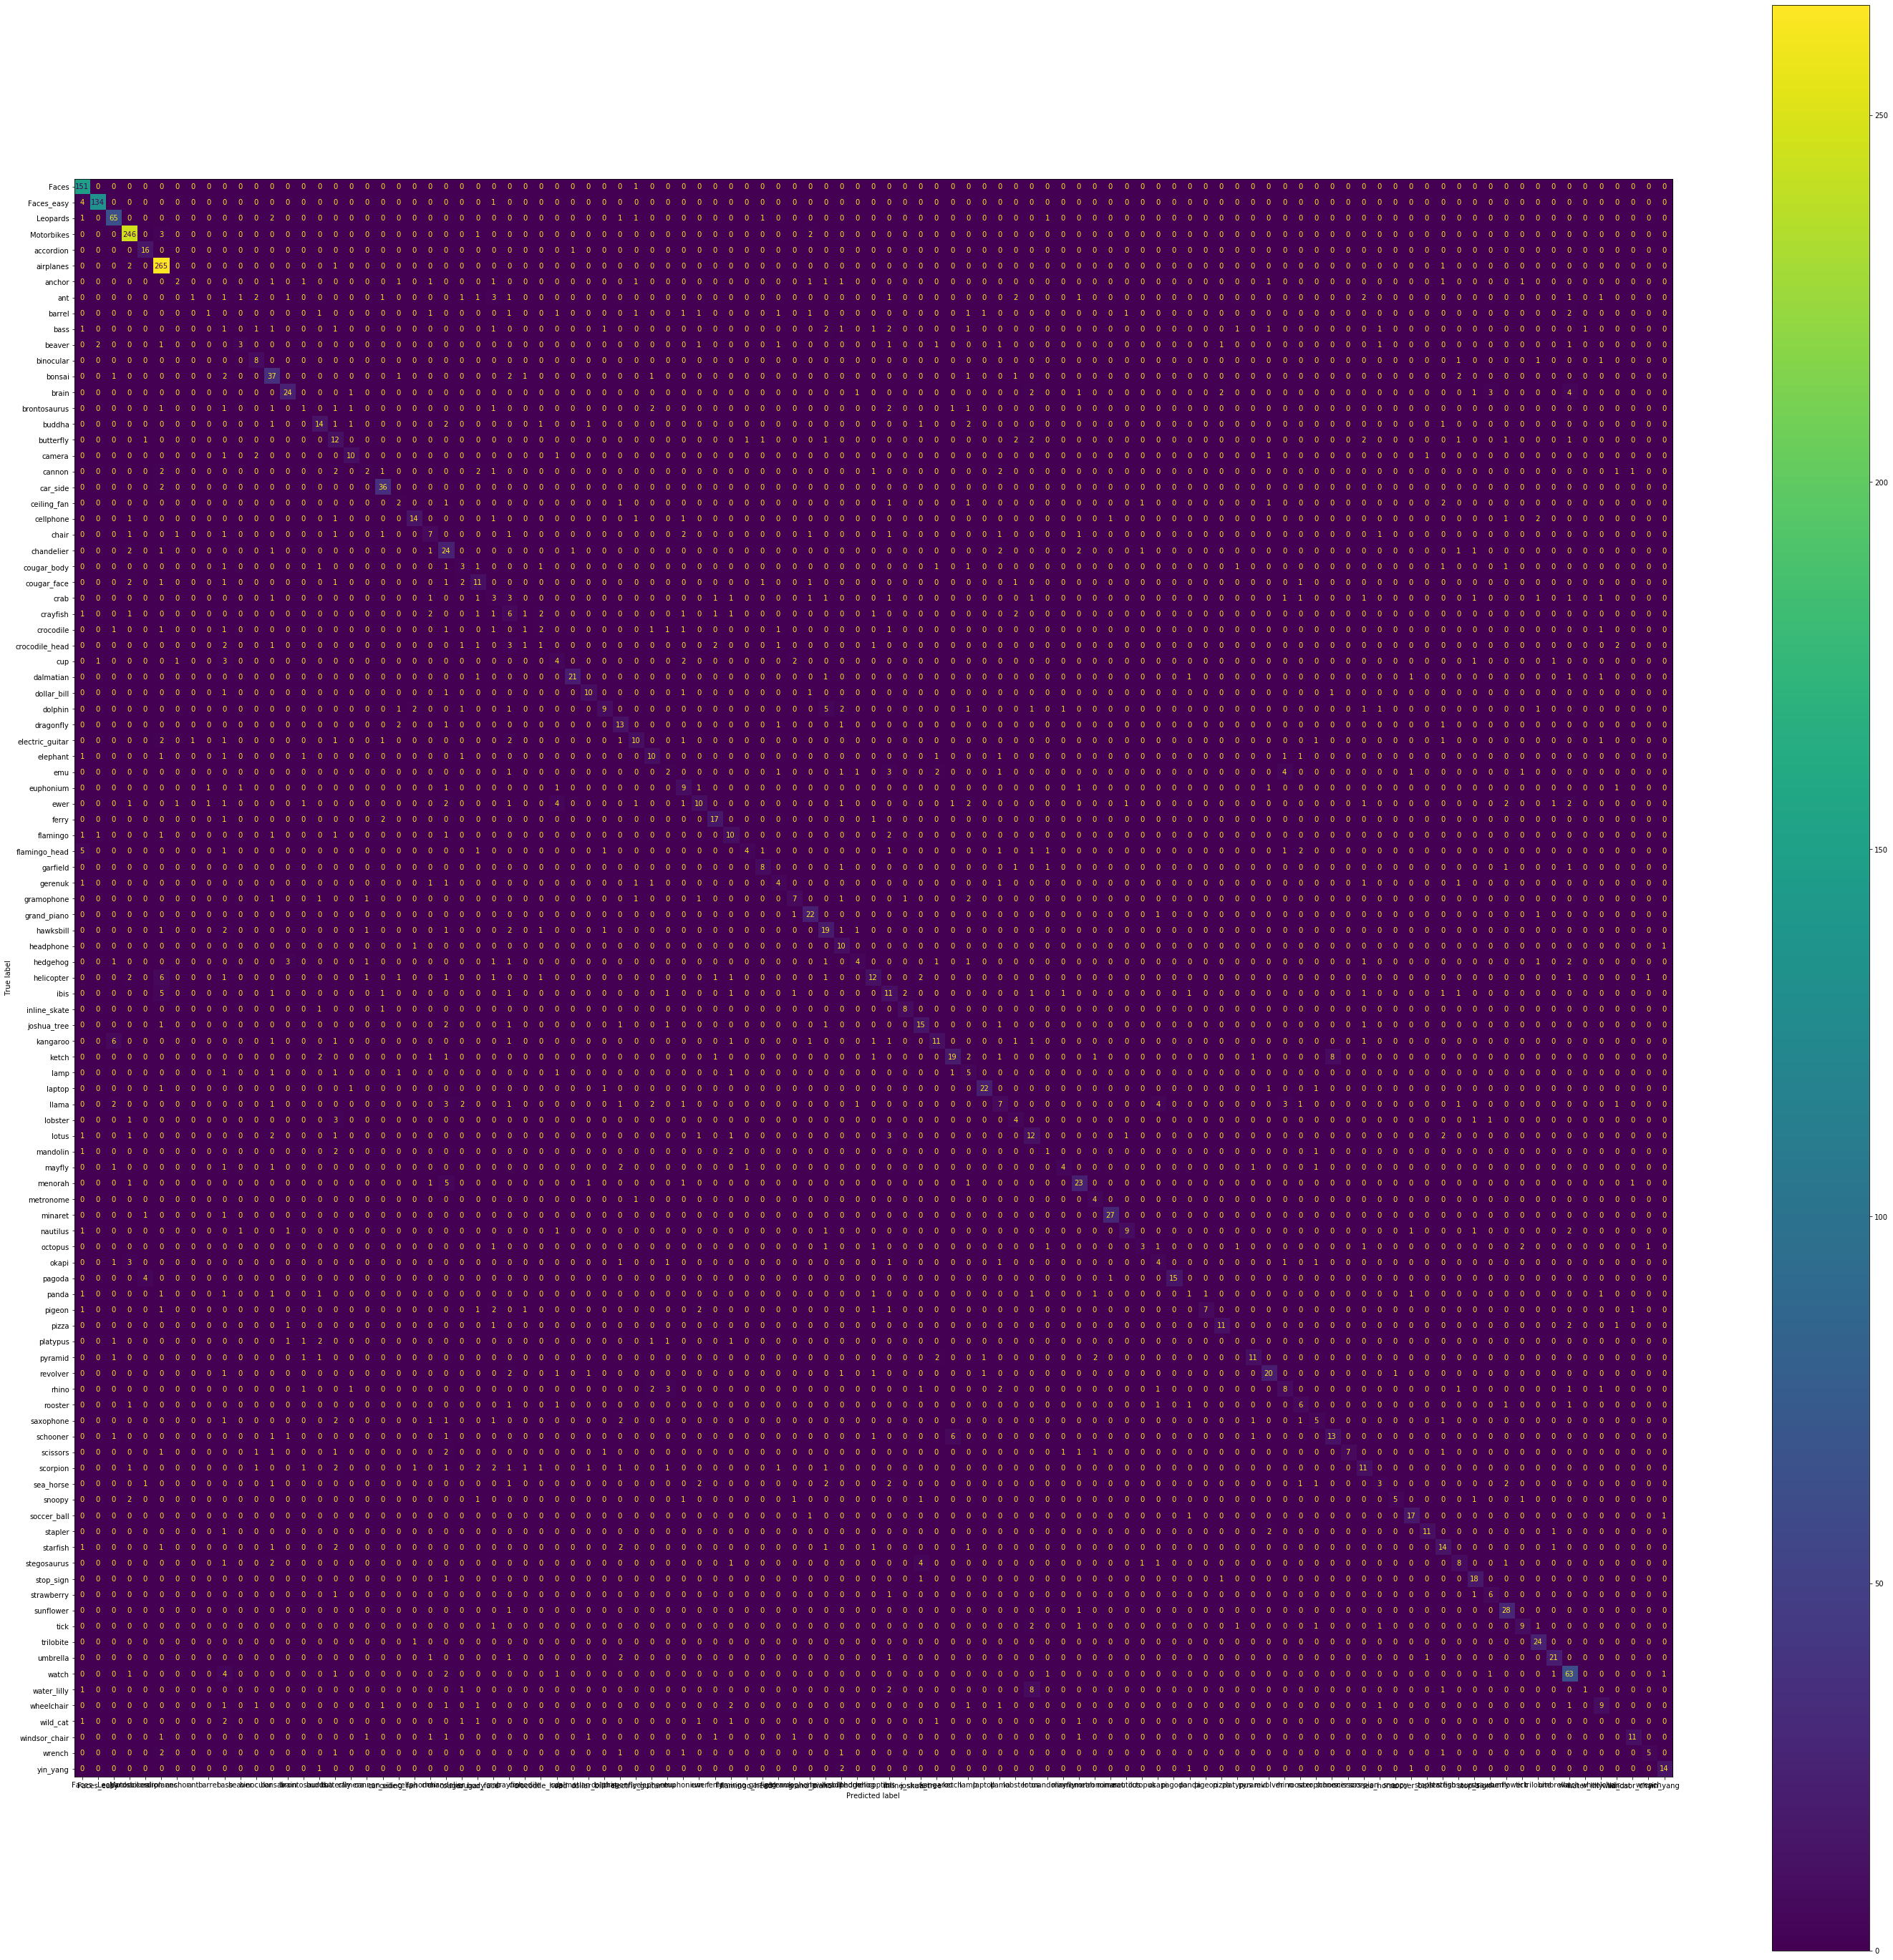

In [59]:
cm_fine_tuned = confusion_matrix(y_fine_tuned, y_pred_fine_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_fine_tuned, display_labels=data.categories)
fig, ax = plt.subplots(figsize=(50,50))
disp.plot(ax=ax)
disp.figure_.savefig('conf_mat_fine_tuned.png')
print("Plot saved")
plt.show()

## sklearn.metrics.classification_report

In [60]:
def auc_prc(true_y, pred_y, confidence):
    precision = dict()
    recall = dict()
    average_precision = dict()

    true_prediction = pred_y == true_y

    for i in range(101):
        class_indices = np.nonzero(true_y == i)[0]

        if len(class_indices) == 0:
            continue

        precision[i], recall[i], _ = precision_recall_curve(true_prediction[class_indices], confidence[class_indices])
        average_precision[i] = average_precision_score(true_prediction[class_indices], confidence[class_indices])

    precision["micro"], recall["micro"], _ = precision_recall_curve(
      true_prediction, confidence
    )
    average_precision["micro"] = average_precision_score(true_prediction, confidence, average="micro")

    display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
    )
    display.plot()
    _ = display.ax_.set_title("Micro-averaged Precision-Recall ")

In [61]:
print("CNN")
print(classification_report(y_cnn, y_pred_cnn, target_names=data.categories))

CNN
                 precision    recall  f1-score   support

          Faces       0.51      0.90      0.65       152
     Faces_easy       0.96      0.97      0.96       139
       Leopards       0.67      0.54      0.60        72
     Motorbikes       0.98      0.95      0.96       252
      accordion       0.88      0.82      0.85        17
      airplanes       0.89      0.93      0.91       269
         anchor       0.75      0.21      0.33        14
            ant       0.00      0.00      0.00        21
         barrel       0.04      0.07      0.05        15
           bass       0.50      0.11      0.18        18
         beaver       0.27      0.21      0.24        14
      binocular       0.57      0.36      0.44        11
         bonsai       0.47      0.47      0.47        49
          brain       0.49      0.51      0.50        39
   brontosaurus       0.20      0.08      0.11        13
         buddha       0.30      0.52      0.38        25
      butterfly       0.48

/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
print("Frozen")
print(classification_report(y_frozen, y_pred_frozen, target_names=data.categories))

Frozen
                 precision    recall  f1-score   support

          Faces       0.54      0.56      0.55       152
     Faces_easy       0.55      0.83      0.66       139
       Leopards       0.57      0.71      0.63        72
     Motorbikes       0.64      0.87      0.73       252
      accordion       0.42      0.47      0.44        17
      airplanes       0.63      0.71      0.67       269
         anchor       0.17      0.07      0.10        14
            ant       0.00      0.00      0.00        21
         barrel       0.00      0.00      0.00        15
           bass       0.00      0.00      0.00        18
         beaver       0.00      0.00      0.00        14
      binocular       0.50      0.09      0.15        11
         bonsai       0.25      0.37      0.30        49
          brain       0.70      0.41      0.52        39
   brontosaurus       0.00      0.00      0.00        13
         buddha       0.23      0.36      0.28        25
      butterfly       0

/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
print("Fine-tuned")
print(classification_report(y_fine_tuned, y_pred_fine_tuned, target_names=data.categories))

Fine-tuned
                 precision    recall  f1-score   support

          Faces       0.87      0.99      0.93       152
     Faces_easy       0.97      0.96      0.97       139
       Leopards       0.80      0.90      0.85        72
     Motorbikes       0.91      0.98      0.94       252
      accordion       0.70      0.94      0.80        17
      airplanes       0.88      0.99      0.93       269
         anchor       0.40      0.14      0.21        14
            ant       0.50      0.05      0.09        21
         barrel       0.33      0.07      0.11        15
           bass       0.03      0.06      0.04        18
         beaver       0.50      0.21      0.30        14
      binocular       0.50      0.73      0.59        11
         bonsai       0.60      0.76      0.67        49
          brain       0.75      0.62      0.68        39
   brontosaurus       0.12      0.08      0.10        13
         buddha       0.56      0.56      0.56        25
      butterfly    

## AUC-PRC plot

CNN


/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/li

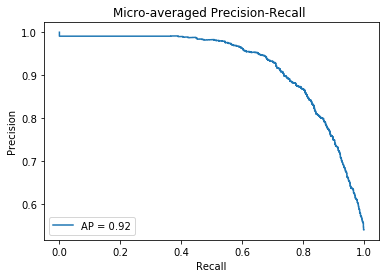

In [64]:
print("CNN")
auc_prc(y_cnn, y_pred_cnn, confidence_cnn)

Frozen


/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/li

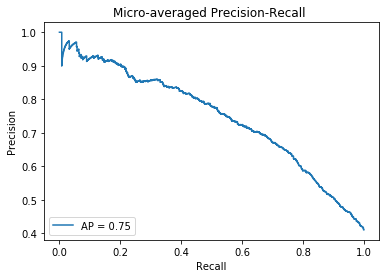

In [65]:
print("Frozen")
auc_prc(y_frozen, y_pred_frozen, confidence_frozen)

Fine-tuned


/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
/home/nastya/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:864: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


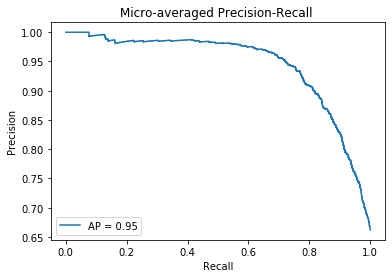

In [66]:
print("Fine-tuned")
auc_prc(y_fine_tuned, y_pred_fine_tuned, confidence_fine_tuned)

## The top-1 error rate in %

In [67]:
def top_1_error_rate(model_name, cm):
    print(f"{model_name}: {(1-np.min(cm.diagonal()/cm.sum(axis=1)))}")

In [68]:
top_1_error_rate("CNN", cm_cnn)
top_1_error_rate("Frozen", cm_frozen)
top_1_error_rate("Fine-tuned", cm_fine_tuned)

CNN: 1.0
Frozen: 1.0
Fine-tuned: 1.0


## Visualize filters and corresponding feature maps of the first and second Conv2d layers 

## CNN

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

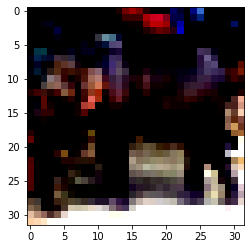

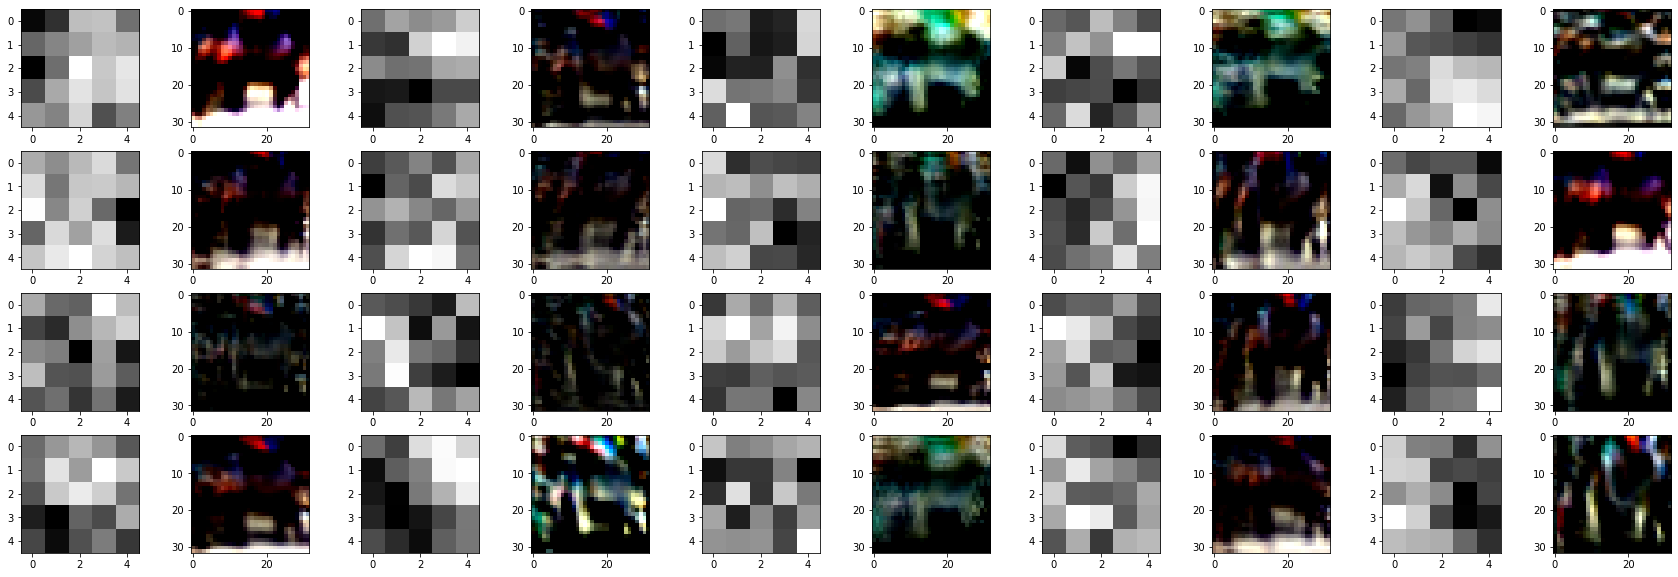

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

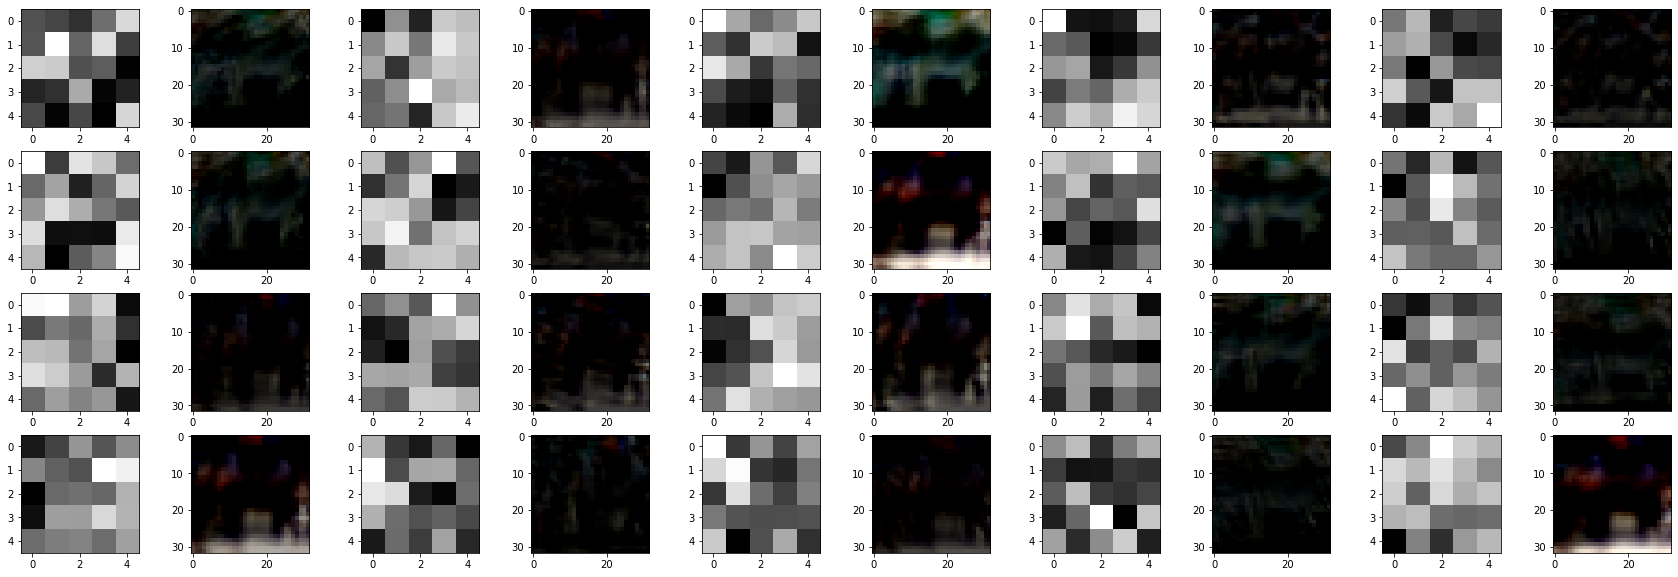

In [69]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = 7
img = np.squeeze(images[idx])

plt.imshow(np.asarray(np.moveaxis(img, 0, -1)))

weights_1 = model.conv1.weight.data
w_1 = weights_1.numpy()

fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 4

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w_1[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(np.moveaxis(img, 0, -1), -1, w_1[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

weights_2 = model.conv2.weight.data
w_2 = weights_2.numpy()


fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 4

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w_2[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(np.moveaxis(img, 0, -1), -1, w_2[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

Модель враховує колір, blind фільтрів немає, лише деякі фільтри враховують фон

# Frozen pre-trained ResNet as feature extractor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

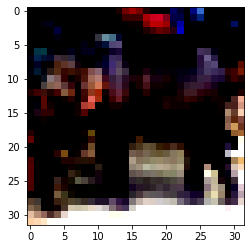

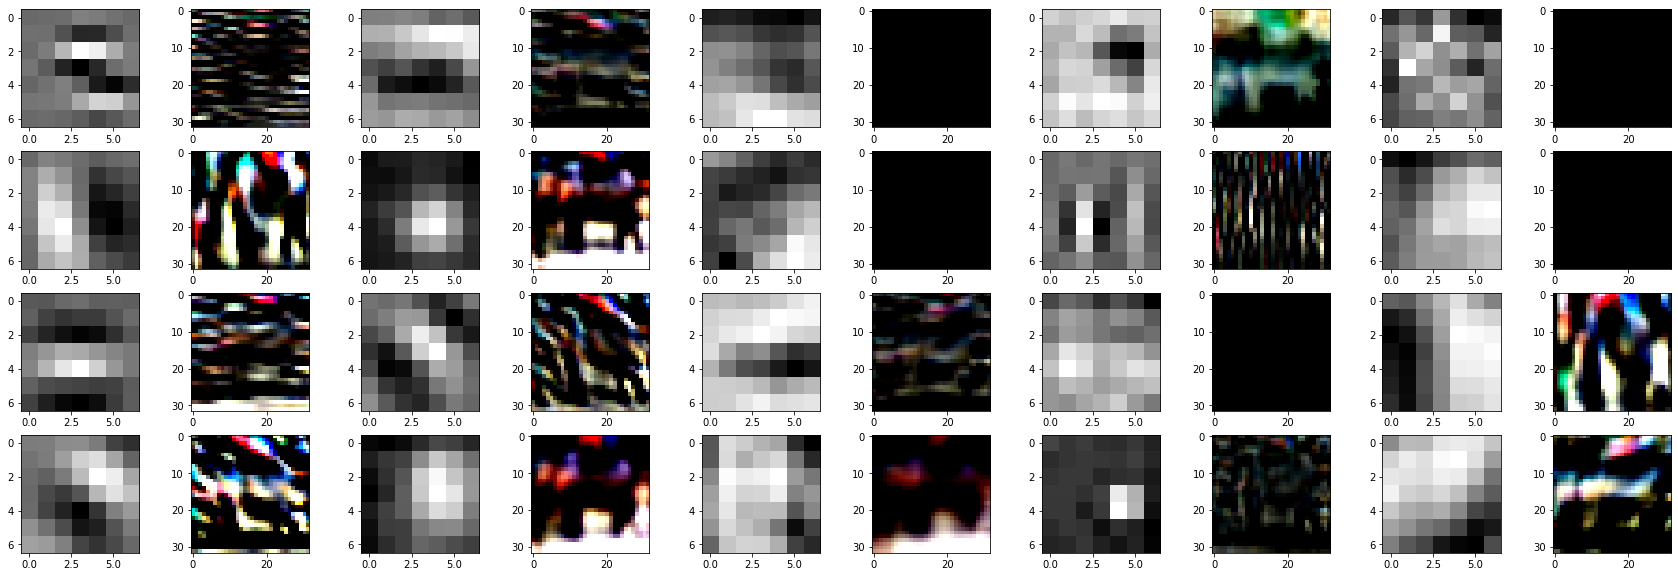

In [70]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = 7
img = np.squeeze(images[idx])

plt.imshow(np.asarray(np.moveaxis(img, 0, -1)))

weights_1 = model_conv_frozen.conv1.weight.data
w_1 = weights_1.numpy()

fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 4

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w_1[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(np.moveaxis(img, 0, -1), -1, w_1[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

Модель враховує колір, має декілька blind фільтрів, деякі фільтри не враховують фон. 

# Fine-tuned pre-trained ResNet

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

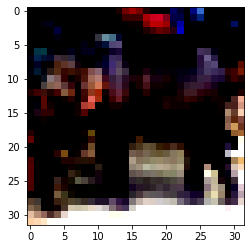

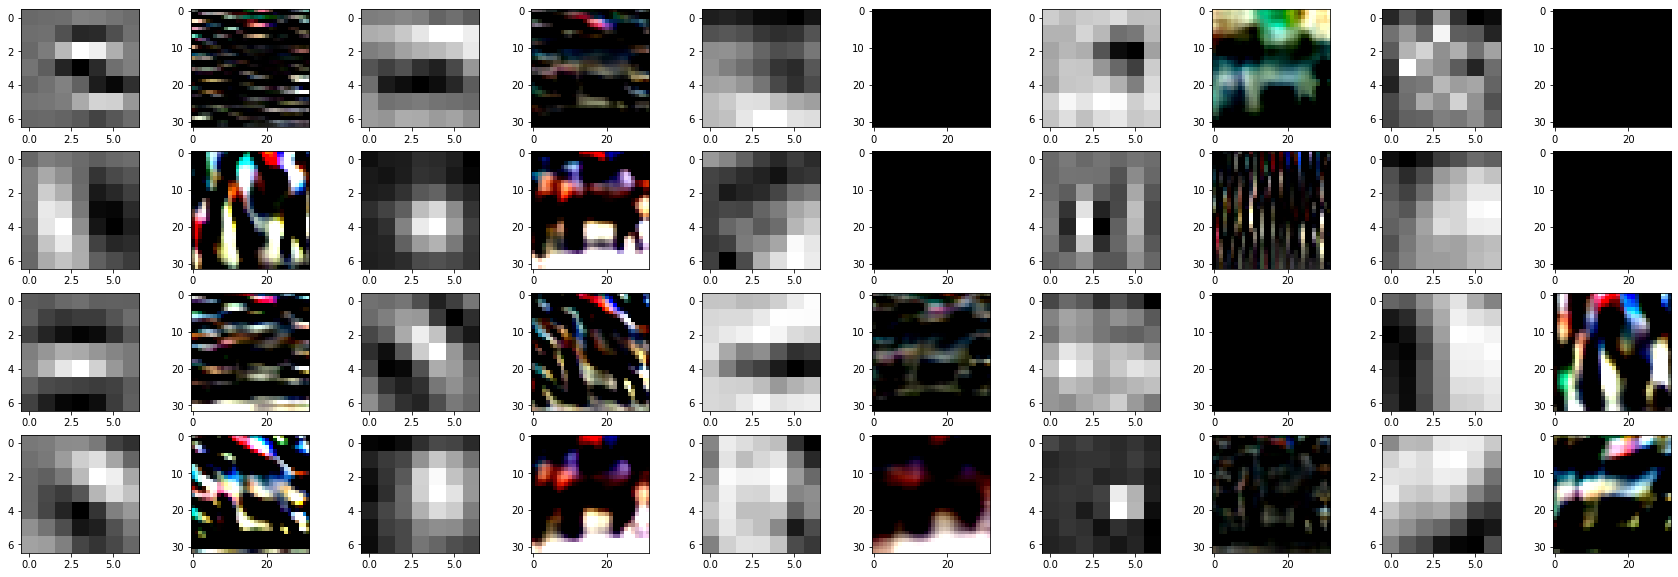

In [71]:
dataiter = iter(test_data_loader)
images, labels = dataiter.next()
images = images.numpy()

idx = 7
img = np.squeeze(images[idx])

plt.imshow(np.asarray(np.moveaxis(img, 0, -1)))

weights_1 = fine_tuned.conv1.weight.data
w_1 = weights_1.numpy()

fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 4

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w_1[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(np.moveaxis(img, 0, -1), -1, w_1[int((i-1)/2)][0])
        plt.imshow(c)
plt.show()

In [ ]:
Модель враховує колір,має декілька blind фільтрів, деякі фільтри не враховують фон.